In [6]:
import numpy as np
import matplotlib.pyplot as plt
from math import e, exp, log, sqrt
from scipy.stats import norm
plt.style.use('ggplot')

np.random.seed(42)
%matplotlib inline

In this notebook, we'll explore using Gaussian noise to provide differential privacy guarantees. It has some nice properties, including the fact that we are used to reasoning about normally distributed error/noise!

Let's use our same dataset to get an idea and compare between these different implementations of differential privacy. 

In [7]:
mid_level_age = 45
mid_level_salary = 50000

age_scale = 10 #scale represents one standard deviation
salary_scale = 10000

salaries = [round(np.random.normal(mid_level_salary,salary_scale)) for _ in range(100)]
ages = [round(np.random.normal(mid_level_age,age_scale)) for _ in range(100)]

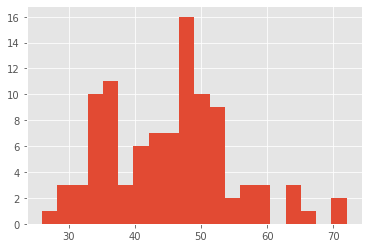

In [8]:
plt.hist(ages, bins=20);

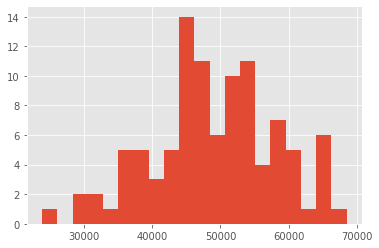

In [9]:
plt.hist(salaries, bins=20);

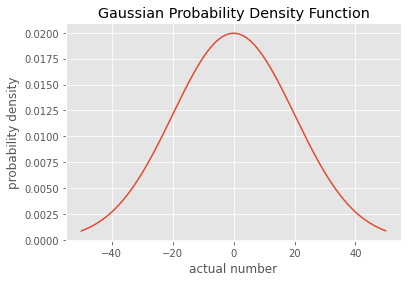

In [10]:
loc = 0
scale = 20

x = np.arange(-50., 50., 0.1)
pdf = norm.pdf(x, loc, scale)

fig,ax= plt.subplots()
ax.plot(x, pdf)
ax.set_title('Gaussian Probability Density Function')
ax.set_xlabel('actual number')
ax.set_ylabel('probability density');

In order to scale our Gaussian distribution to meet differential privacy guarantees, we need to define our sensitivity, delat and epsilon. Let's keep it close to our prior notebook (with the exception that Laplace never needs Delta!). 

NOTE: This formula is only good for epsilon < 1 and is not as optimized (i.e. it adds more noise than necessary to meet the guarantees!). For real problems, please use a well-reviewed differential privacy library.

In [11]:
sensitivity=1
delta = 10**-5
epsilon=0.99
sigma_squared = (2*sensitivity**2*log(1.25/delta))/epsilon**2 
sigma_squared

23.94871751103854

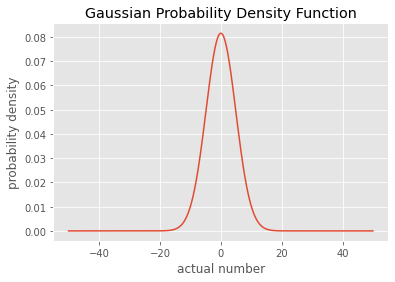

In [12]:
loc = 0
scale = sqrt(sigma_squared)

x = np.arange(-50., 50., 0.1)
pdf = norm.pdf(x, loc, scale)

fig,ax= plt.subplots()
ax.plot(x, pdf)
ax.set_title('Gaussian Probability Density Function')
ax.set_xlabel('actual number')
ax.set_ylabel('probability density');

How does changing the sensitivity affect our overall noise / error distribution?

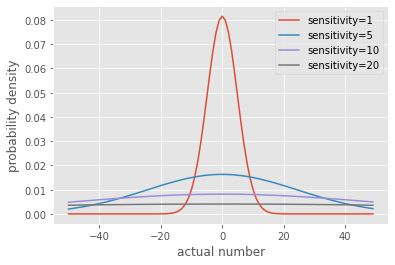

In [13]:
mu_val = 0
sensitivity_list = [1, 5, 10, 20]
delta = 10**-5

x = np.arange(-50., 50., 1)
fig,ax= plt.subplots()


for sensitivity in sensitivity_list:
    #pdf = np.exp(-abs(x-mu_val)/b_val)/(2.*b_val)
    gauss_scale = sqrt((2*sensitivity**2*log(1.25/delta))/epsilon**2)
    pdf = norm.pdf(x, mu_val, gauss_scale)
    ax.plot(x, pdf, label='sensitivity=%s' % sensitivity)
    
ax.set_xlabel('actual number')
ax.set_ylabel('probability density')
ax.legend()

Can we compare this to what we saw with Laplacian noise/error?

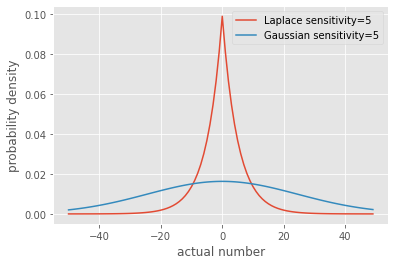

In [14]:
mu_val = 0
sensitivity_list = [5]
delta = 10**-5
epsilon=0.99

x = np.arange(-50., 50., 1)
fig,ax= plt.subplots()


for sensitivity in sensitivity_list:
    b_val = sensitivity/epsilon
    pdf = np.exp(-abs(x-mu_val)/b_val)/(2.*b_val)
    ax.plot(x, pdf, label='Laplace sensitivity=%s' % sensitivity)

    gauss_scale = sqrt((2*sensitivity**2*log(1.25/delta))/epsilon**2)
    pdf = norm.pdf(x, mu_val, gauss_scale)
    ax.plot(x, pdf, label='Gaussian sensitivity=%s' % sensitivity)
    
ax.set_xlabel('actual number')
ax.set_ylabel('probability density')
ax.legend()

### Guassian DP Mechanism

Let's now implement a toy-example, please do not use this in real life! Instead, use a properly audited and well-known open-source library. :)

In [15]:
epsilon = 0.99 # Must be less than 1 to use this implementation!
sensitivity = 1 
delta=10**-5


def gaussian_dp_mechanism(value, epsilon, sensitivity=sensitivity):
    # Please do not use this function in real life - it is susceptible to well known attacks
    # instead, use a well-known and audited open-source DP library 
    orig_value = value
    gauss_scale = sqrt((2*sensitivity**2*log(1.25/delta))/epsilon**2)
    value =  np.random.normal(value, gauss_scale)
    print("Noise: {}".format(value - orig_value))
    return value

In [16]:
gaussian_dp_mechanism(len(ages), epsilon)

Noise: 1.75091927910006


101.75091927910006

In [17]:
def filter_bounds(value, lower_bound, upper_bound):
    if value < lower_bound:
        return lower_bound
    elif value > upper_bound:
        return upper_bound
    return value

What about if we want to answer a more complicated query, like a sum? We need to know exactly how much one person can affect our outcome. Since we know this is a dataset of working persons, we might choose upper and lower bounds to artificially limit the amount that one person can affect the dataset. 

Let's take a look at how that might work with our ages!

In [18]:
bounded_ages = [filter_bounds(age, 20, 70) for age in ages]

In [19]:
gaussian_dp_mechanism(np.sum(bounded_ages), epsilon, sensitivity=50)

Noise: 137.21675881497413


4663.216758814974

In [20]:
sum(ages)

4528

And we can see how we want to spend our budget and adjust. Our count has lower sensitivity, so we will spend less on it. Of course, you may need to adjust your queries not only based on sensitivity, but also how accurate you want your query result to be!

In [21]:
epsilon_for_sum = 0.79
epsilon_for_count = 0.20
summed_ages = gaussian_dp_mechanism(np.sum(bounded_ages), epsilon_for_sum, sensitivity=50)
count_ages = gaussian_dp_mechanism(len(bounded_ages), epsilon_for_count, sensitivity=1)

mean_age = summed_ages / count_ages
mean_age

Noise: 332.0995166206894
Noise: 25.527328637215277


38.7015287377063

TODO!! Equation for covariance + Gaussian noise.

What if we found a clever way to calculate covariance, that didn't require adding noise to each data point... This is starting to get into how designers of these systems actually think through methods that are available. It also can point us into thinking about sensitivity in a calculable way!

### Comparing Laplace and Gaussian Noise

Let's take a look at how Laplace and Gaussian noise compare with one another. To do so, we'll want to analyze how many distinct statistics a user can affect (this is also the l0_sensitivity). In this example, we'll use a better approximation for the Gaussian noise.

NOTE: These functions were built based on [the Google Differential Privay Library implementation of Gaussian noise.](https://github.com/google/differential-privacy/blob/0e95b99af5fedff95b8cab3739009bbc1366c068/go/noise/gaussian_noise.go)

In [22]:
def delta_for_gaussian(sigma, l0_sensitivity, linf_sensitivity, epsilon):
    l2_sensitivity = linf_sensitivity * sqrt(l0_sensitivity)
    a = l2_sensitivity / (2*sigma)
    b = epsilon * sigma / l2_sensitivity
    c = exp(epsilon)
    
    if np.isinf(c): 
        return 0
    if np.isinf(b):
        return 0
    return norm.cdf (a-b) - norm.cdf(-a-b)

In [23]:
gaussianSigmaAccuracy = 1e-3

def sigma_for_gaussian(l0_sensitivity, linf_sensitivity, epsilon, delta):
    if delta >=1:
        return 0
    
    l2_sensitivity = linf_sensitivity * sqrt(l0_sensitivity)
    upper_bound = l2_sensitivity
    
    while delta_for_gaussian(upper_bound, l0_sensitivity, linf_sensitivity, epsilon) > delta:
        lower_bound = upper_bound
        upper_bound = upper_bound * 2
    
    while upper_bound - lower_bound > gaussianSigmaAccuracy * lower_bound:
        middle = lower_bound * 0.5 + upper_bound * 0.5
        if delta_for_gaussian(middle, l0_sensitivity, linf_sensitivity, epsilon) > delta:
            lower_bound = middle
        else:
            upper_bound = middle
            
    return upper_bound

In [24]:
epsilon = 1
delta = 10**-5

In [26]:
l0_sensitivity = 1 # Number of statistics one user influences
sensitivity = 5

laplace_std_dev = sqrt(2)*l0_sensitivity
gauss_std_dev = sigma_for_gaussian(l0_sensitivity, sensitivity, epsilon, delta)

In [27]:
gauss_std_dev

21.42578125

In [28]:
laplace_std_dev

1.4142135623730951

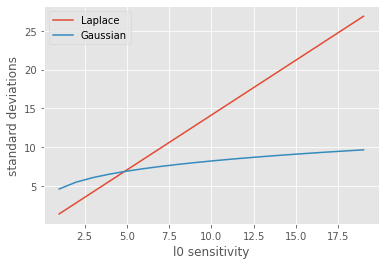

In [35]:
x = np.arange(1., 20, 1)
fig,ax= plt.subplots()

laplace_stddev = sqrt(2)*x
ax.plot(x, laplace_stddev , label='Laplace')


gauss_std_dev = [sqrt(sigma_for_gaussian(l0, sensitivity, epsilon, delta)) for l0 in x]
ax.plot(x, gauss_std_dev, label='Gaussian')
    
ax.set_xlabel('l0 sensitivity')
ax.set_ylabel('standard deviations')
ax.legend()